# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

## Lib importing 

In [1]:
#Import libs
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib import pyplot

from sklearn.model_selection import train_test_split

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras import backend as T

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import concatenate
from tensorflow.python.client import device_lib
import tensorflow as tf 

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
#To see if cpu and gpu availability
print(device_lib.list_local_devices())
#only cpu

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11923008365013686488
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8811423967965145477
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
#Tensorflow version
tf.__version__

'2.1.0'

In [4]:
#Opencv version
cv2.__version__

'3.4.4'

### Change current working directory to project folder (1 mark)

In [5]:
#Set working directory
import os
os.chdir('C:/Users/sarth/Anaconda projects/great learning/AI/CNN/')

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [6]:
#Set path from where we have to import data
DATA_PATH = 'C:/Users/sarth/Anaconda projects/great learning/AI/CNN/Project/'
data = np.load(DATA_PATH + 'images.npy',allow_pickle=True) #Loding dataset

In [7]:
type(data) #Check type of data

numpy.ndarray

In [8]:
data.shape  #Check shape of data

(409, 2)

### Check one sample from the loaded "images.npy" file  (4 marks)

In [9]:
data[0] #Understanding data

array([array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8),
       list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 

In [10]:
data[0][0] #here are just images

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [11]:
data[0][1] #here is the information about mask and all

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

In [12]:
data[0][1][0] 

{'label': ['Face'],
 'notes': '',
 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
  {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
 'imageWidth': 650,
 'imageHeight': 333}

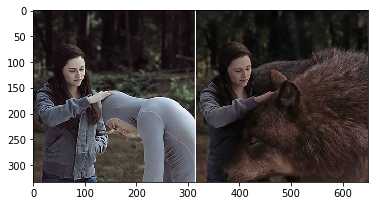

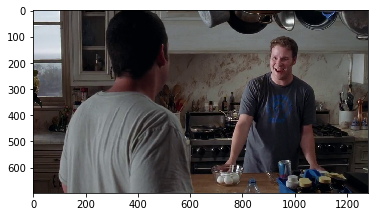

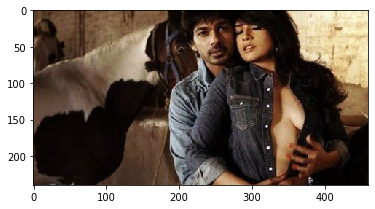

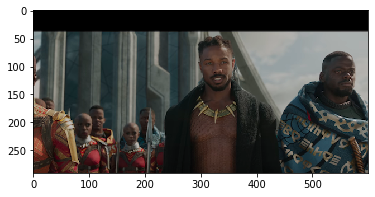

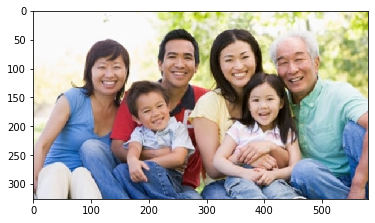

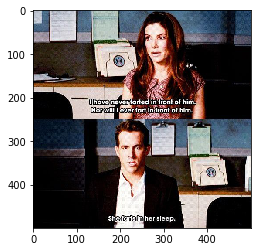

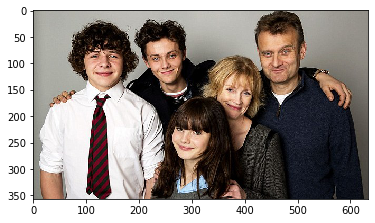

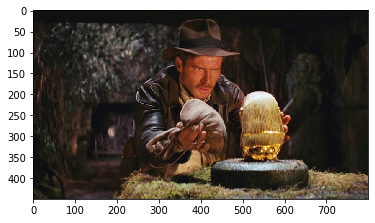

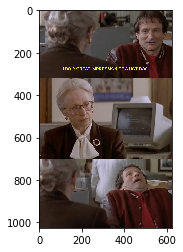

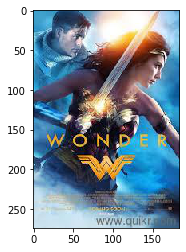

In [13]:
#To display 10 images
for i in range(10):
    pyplot.imshow(data[i][0])
    pyplot.show()


### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [14]:
IMAGE_WIDTH =224 
IMAGE_HEIGHT =224 

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [15]:
#Extracting mask and images seperately
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1
        

In [16]:
#Cross check if they are of same length or not
print(len(X_train))
print(len(masks))

#yes they are

409
409


### Print the shape of X_train and mask array  (1 mark)

In [17]:
X_train.shape
#Here you can see 409 images of 3 channels of size 224*224

(409, 224, 224, 3)

In [18]:
masks.shape
#Here you can see 409 mask of 1 channels of size 224*224

(409, 224, 224)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

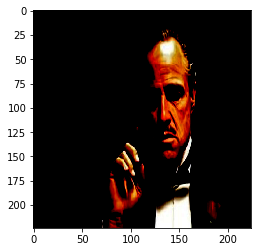

In [19]:
#see the data and visualize a image
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

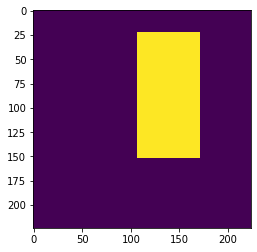

In [20]:
#Mask of that image
pyplot.imshow(masks[n])

#### displaying 10 images and 10 masks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


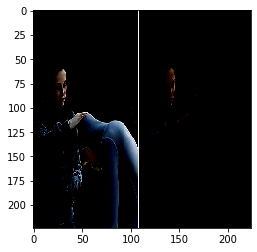

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


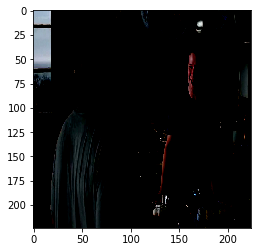

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


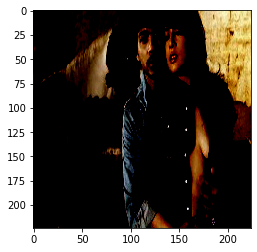

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


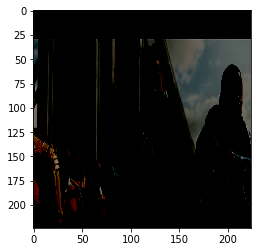

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


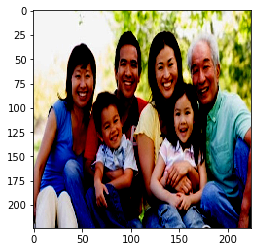

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


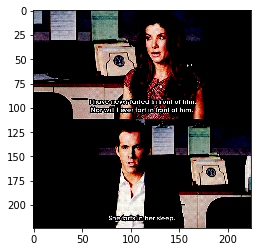

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


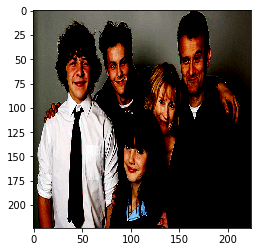

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


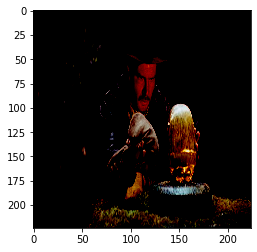

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


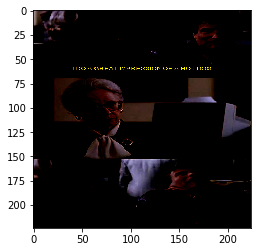

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


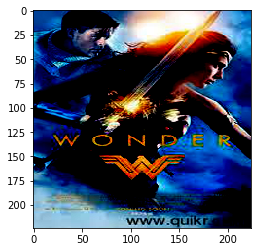

In [21]:
for i in range(10):
    pyplot.imshow(X_train[i])
    pyplot.show()


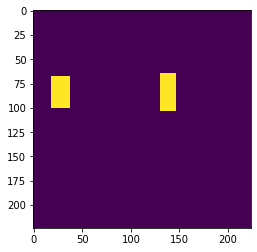

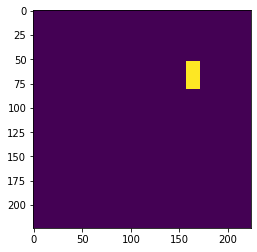

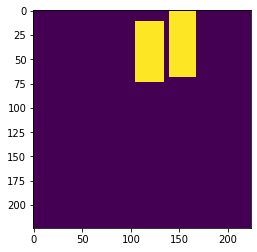

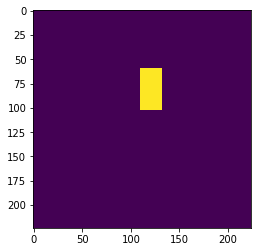

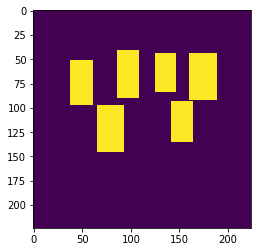

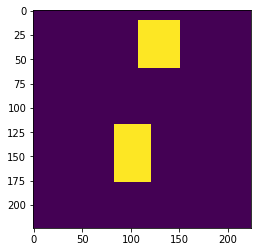

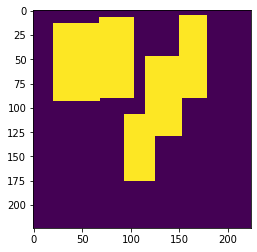

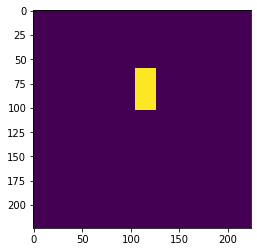

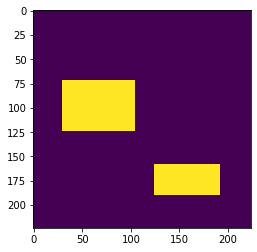

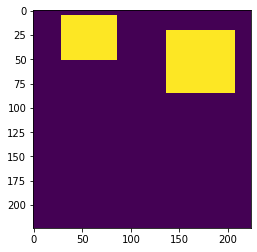

In [22]:
for i in range(10):
    pyplot.imshow(masks[i])
    pyplot.show()


## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [23]:
# SETTINGS up information
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
IMAGE_HEIGHT = 224 #image ht
IMAGE_WIDTH = 224 #image wt
CHANNEL = 3 #channel 3
PATIENCE = 2 # Patience for early stopping


In [24]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=ALPHA,  weights='imagenet') # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable
        
    #Upsampling feature maps to size 224*224 so to input in unet    
    block1 = model.get_layer("conv_pw_1_relu").output 
    block2 = model.get_layer("conv_pw_1_relu").output
    block3 = model.get_layer("conv_pw_3_relu").output
    block4 = model.get_layer("conv_pw_5_relu").output
    block5 = model.get_layer("conv_pw_11_relu").output
    block6 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = UpSampling2D()(x)
    x = Conv2D(3, kernel_size=1, activation="relu")(x)
    
    #Defining unet
    base_model = Unet('mobilenet', activation='sigmoid', encoder_weights='imagenet') #unet model
    
    
    l1 = Conv2D(3, (1, 1))(x) # map N channels data to 3 channels
    out = base_model(l1)
    #l2 = Conv2D(3, (1, 1), activation='sigmoid')(out)
    l2 = Conv2D(3, (1, 1), activation='sigmoid')(out)


    return Model(inputs=model.input, outputs=l2)   


### Call the create_model function

In [25]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

C:\Users\sarth\Anaconda3\envs\gputest\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [26]:
T.set_image_data_format('channels_last')  # TF dimension ordering
smooth = 1.

def dice_coef(y_true, y_pred):
    intersection = T.sum(y_true * y_pred, axis=[1,2,3])
    union = T.sum(y_true, axis=[1,2,3]) + T.sum(y_pred, axis=[1,2,3])
    return T.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


### Define loss

In [27]:
def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [28]:
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

### Define checkpoint and earlystopping

In [29]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_dice_coef", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="loss", patience=2, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 


### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [30]:
masks2=masks
print(masks2.shape)
masks2 = masks2.reshape(masks2.shape[0], masks2.shape[1], masks2.shape[2], 1)
print(masks2.shape)

(409, 224, 224)
(409, 224, 224, 1)


In [31]:
#Splitting data into test and train so to give reference to the regularization technique
#10% for testing and 90% training
X_train2, X_test, y_train, y_test = train_test_split(X_train, masks2, test_size=0.10, random_state=1)

In [32]:
#Seeing traing set shape
print(X_train2.shape)
print(y_train.shape)

(368, 224, 224, 3)
(368, 224, 224, 1)


In [33]:
#Seeing test set shape
print(X_test.shape)
print(y_test.shape)

(41, 224, 224, 3)
(41, 224, 224, 1)


In [34]:
#model fitting with required config
model.fit(X_train2, y_train, batch_size=1, epochs=8, validation_data=(X_test, y_test), callbacks=[checkpoint, reduce_lr, stop], verbose=1)


Train on 368 samples, validate on 41 samples
Epoch 1/8
368/368 [==============================] - 54s 148ms/step - loss: 0.7632 - dice_coef: 0.2368 - val_loss: 0.7658 - val_dice_coef: 0.2342

Epoch 00001: val_dice_coef improved from -inf to 0.23418, saving model to model-0.76.h5
Epoch 2/8
368/368 [==============================] - 43s 118ms/step - loss: 0.7402 - dice_coef: 0.2598 - val_loss: 0.7294 - val_dice_coef: 0.2706

Epoch 00002: val_dice_coef improved from 0.23418 to 0.27063, saving model to model-0.74.h5
Epoch 3/8
368/368 [==============================] - 43s 118ms/step - loss: 0.7121 - dice_coef: 0.2879 - val_loss: 0.7029 - val_dice_coef: 0.2971

Epoch 00003: val_dice_coef improved from 0.27063 to 0.29712, saving model to model-0.71.h5
Epoch 4/8
368/368 [==============================] - 45s 121ms/step - loss: 0.6748 - dice_coef: 0.3252 - val_loss: 0.6812 - val_dice_coef: 0.3188

Epoch 00004: val_dice_coef improved from 0.29712 to 0.31876, saving model to model-0.67.h5
Epoch 

## Evaluating model

In [35]:
#On train set
model.evaluate(X_train2, y_train, verbose=1)

368/368 [==============================] - 449s 1s/step


[0.2851528914078422, 0.7136891484260559]

In [36]:
#On test set
model.evaluate(X_test, y_test, verbose=1)

41/41 [==============================] - 45s 1s/step


[0.3324160455930524, 0.7022423148155212]

### Get the predicted mask for a sample image   (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


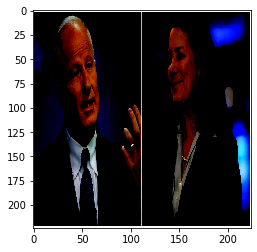

In [36]:
p = 170
sample_image = X_train[p]
plt.imshow(sample_image)

1/1 [==============================] - 2s 2s/step


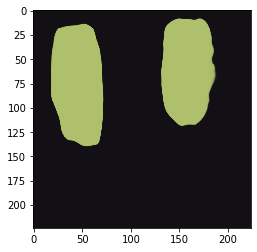

In [37]:
img3 = sample_image.reshape(1, masks2.shape[1], masks2.shape[2], 3) #To convert data in proper format so that model can predict
preds_val3 = model.predict(img3, verbose=1)
pyplot.imshow(preds_val3[0])

####  Second image

In [38]:
#Set n to see which image to visualize
n=20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


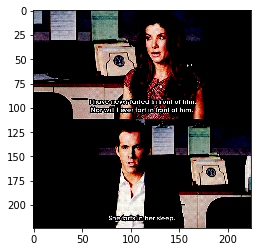

In [39]:
#Visualize image
plt.imshow(X_test[n])

1/1 [==============================] - 0s 52ms/step


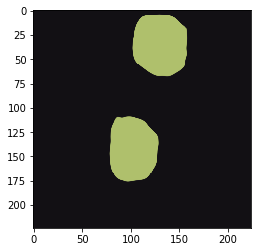

In [40]:
#Visualize mask
img = X_test[n].reshape(1, masks2.shape[1], masks2.shape[2], 3) #To convert data in proper format so that model can predict
preds_val = model.predict(img, verbose=1)
pyplot.imshow(preds_val[0])

#### Third image 

In [41]:
#Set n to see which image to visualize
m=2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


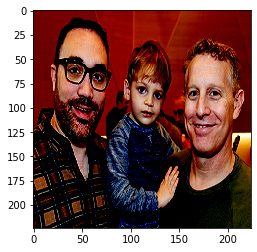

In [42]:
#Visualize image
plt.imshow(X_test[m])

1/1 [==============================] - 0s 53ms/step


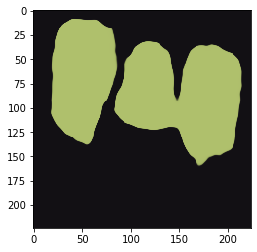

In [43]:
#Visualize mask
img2 = X_test[m].reshape(1, masks2.shape[1], masks2.shape[2], 3) #To convert data in proper format so that model can predict
preds_val2 = model.predict(img2, verbose=1)
pyplot.imshow(preds_val2[0])

### Impose the mask on the image (5 marks)

In [44]:
#As the prediction of each pxel is between 0 and 1 so converting it back again
pred3=preds_val3[0]*255
pred3.shape #prediction is of 3 channel

(224, 224, 3)

(224, 224)


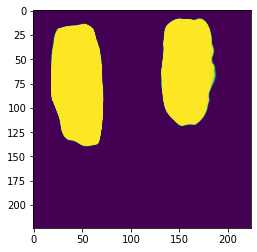

In [45]:
#splitting channels
b, g, r = cv2.split(pred3)
pyplot.imshow(g)
print(g.shape)

In [46]:
g=g.reshape(masks2.shape[1], masks2.shape[2], 1) #putting it in proper shape for mask i.e 224,224,3
print(g.shape)
#pyplot.imshow(g)

(224, 224, 1)


In [47]:
img4=sample_image #Store image to img variable
print(img4.shape) #Cross check step
print(g.shape) #Cross check step

(224, 224, 3)
(224, 224, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


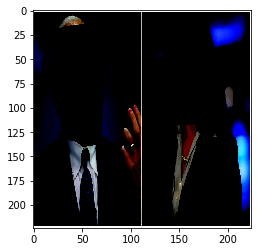

In [48]:
#creating condition where mask is greater than some value, there put black and then plotting value
img5=np.where(g<50 , img4, 0)
pyplot.imshow(img5)

#Note this 50 value was obtained after many trial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


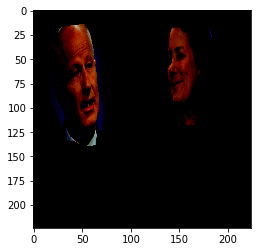

In [49]:
#Here I  have obtained image on mask
img5=np.where(g>50 , img4, 0)
pyplot.imshow(img5)

#### Mask on 2nd image 

In [50]:
#As the prediction of each pxel is between 0 and 1 so converting it back again
pred=preds_val[0]*255
pred.shape #prediction is of 3 channel

(224, 224, 3)

(224, 224)


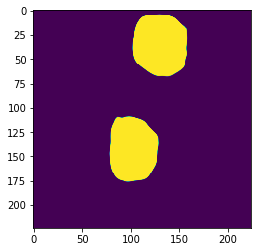

In [51]:
#splitting channels
b, g, r = cv2.split(pred)
pyplot.imshow(g)
print(g.shape)

In [52]:
g=g.reshape(masks2.shape[1], masks2.shape[2], 1) #putting it in proper shape for mask
print(g.shape)
#pyplot.imshow(g)

(224, 224, 1)


In [53]:
img=X_test[n] #Store image to img variable
print(img.shape) #Cross check step
print(g.shape) #Cross check step

(224, 224, 3)
(224, 224, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


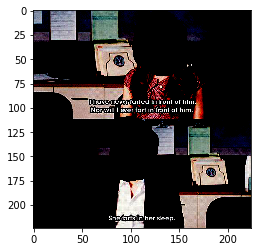

In [54]:
#creating condition where mask is greater than some value, there put black and then plotting value
img2=np.where(g<50 , img, 0)
pyplot.imshow(img2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


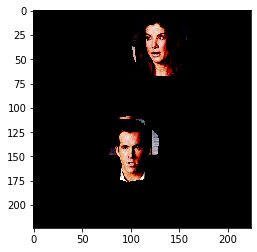

In [55]:
#Here I  have obtained image on mask
img2=np.where(g>50 , img, 0)
pyplot.imshow(img2)

#### Mask on 3rd image 

In [56]:
#As image is between 0 and 1 so converting it back again
pred2=preds_val2[0]*255
pred2.shape #prediction is of 3 channel

(224, 224, 3)

(224, 224)


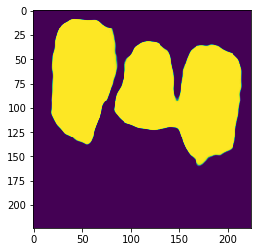

In [57]:
#splitting channels
b, g, r = cv2.split(pred2)
pyplot.imshow(g)
print(g.shape)

In [58]:
g=g.reshape(masks2.shape[1], masks2.shape[2], 1) #putting it in proper shape for mask
print(g.shape)

(224, 224, 1)


In [59]:
img2=X_test[m] #Store image to img variable
print(img2.shape) #Cross check step
print(g.shape) #Cross check step

(224, 224, 3)
(224, 224, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


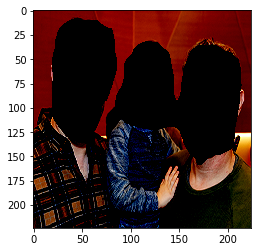

In [60]:
#creating condition where mask is greater than some value, there put black and then plotting value
img3=np.where(g<100 , img2, 0)
pyplot.imshow(img3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


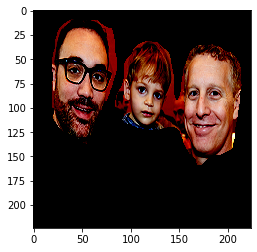

In [61]:
#Here I  have obtained image on mask
img3=np.where(g>100 , img2, 0)
pyplot.imshow(img3)

## Save model and wts

In [93]:
model.save('model_assig2.h5')
model.save_weights('model_assig_wts2.h5')